In [1]:
%cd ../..

/Users/davideleo/Desktop/Projects/research/papers/fl_wavelet_v0


# Malicious detector 
## Fourier Analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78612876..1.708492].


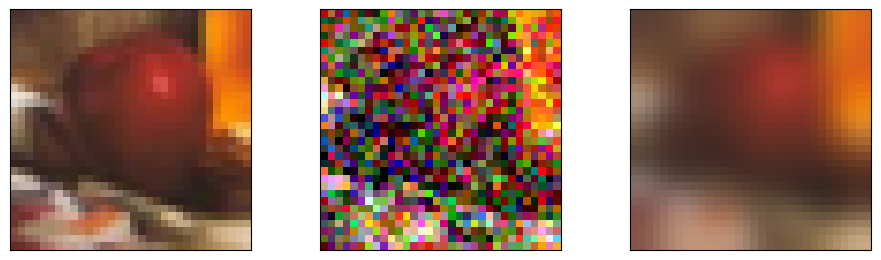

In [2]:
import random 
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
from src.data.cifar100 import get_federation
from src.data.attacks import GaussianBlur, GaussianNoise 
from src.domains.detection import train_detector
from sklearn.decomposition import PCA

random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)

# Load a sample image 
dataset = get_federation(num_shards = 1, alpha = 1000)[0]
dataset["test"].load()
x, _ = dataset["test"][0]
dataset["test"].clear()

# Attacks
gnoise = GaussianNoise(sigma = .5)
gblur = GaussianBlur(kernel_size = 11)

x_noise = gnoise(x)
x_blur = gblur(x)

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 4))
ax0, ax1, ax2 = axs.flatten()

ax0.imshow(torch.swapaxes(torch.swapaxes((x + 1) / 2, 0, 1), 1, 2))
ax0.set_xticks([]); ax0.set_xticklabels([])
ax0.set_yticks([]); ax0.set_yticklabels([])

ax1.imshow(torch.swapaxes(torch.swapaxes((x_noise + 1) / 2, 0, 1), 1, 2))
ax1.set_xticks([]); ax0.set_xticklabels([])
ax1.set_yticks([]); ax0.set_yticklabels([])

ax2.imshow(torch.swapaxes(torch.swapaxes((x_blur + 1) / 2, 0, 1), 1, 2))
ax2.set_xticks([]); ax0.set_xticklabels([])
ax2.set_yticks([]); ax0.set_yticklabels([])

plt.tight_layout(pad = 5.)
plt.show()

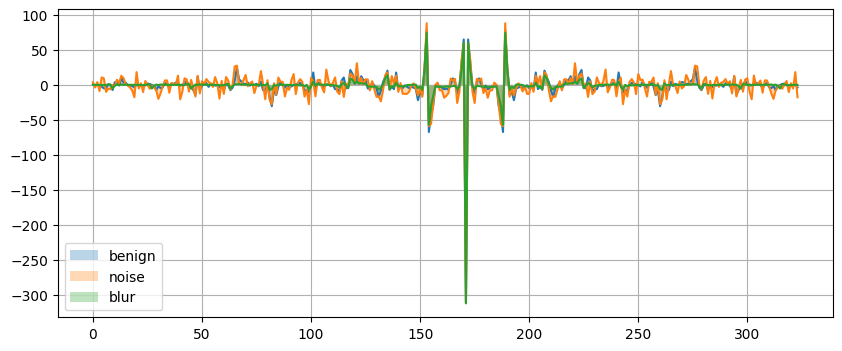

In [3]:
# Fourier domain extraction 
def fourier_domain(
        x: torch.Tensor, 
        beta: float = 1.
) -> torch.Tensor: 
    # Setup
    x = 0.2989 * x[0] + 0.5870 * x[1] + 0.1140 * x[2] 
    h, w = x.size()
    h0, w0 = h // 2, w // 2
    H, W = int(beta * h), int(beta * w)

    x_fft = torch.fft.fft2(x, dim = (-2, -1))
    x_fft = torch.fft.fftshift(x_fft).real 
    x_fft = x_fft[h0-H : h0+H, w0-W : w0+W]
    x_fft = x_fft.reshape(-1)

    return x_fft 

x_benign_fft = fourier_domain(x, beta = .3)
x_noise_fft = fourier_domain(x_noise, beta = .3)
x_blur_fft = fourier_domain(x_blur, beta = .3)


plt.figure(figsize = (10, 4))
plt.plot(torch.arange(x_benign_fft.size(0)), x_benign_fft)
plt.plot(torch.arange(x_noise_fft.size(0)), x_noise_fft)
plt.plot(torch.arange(x_blur_fft.size(0)), x_blur_fft)
plt.fill_between(torch.arange(x_benign_fft.size(0)), 0., x_benign_fft, alpha = .3, label = "benign")
plt.fill_between(torch.arange(x_noise_fft.size(0)), 0., x_noise_fft, alpha = .3, label = "noise")
plt.fill_between(torch.arange(x_blur_fft.size(0)), 0., x_blur_fft, alpha = .3, label = "blur")
plt.legend()
plt.grid()
plt.show()

## Clusters visualization 

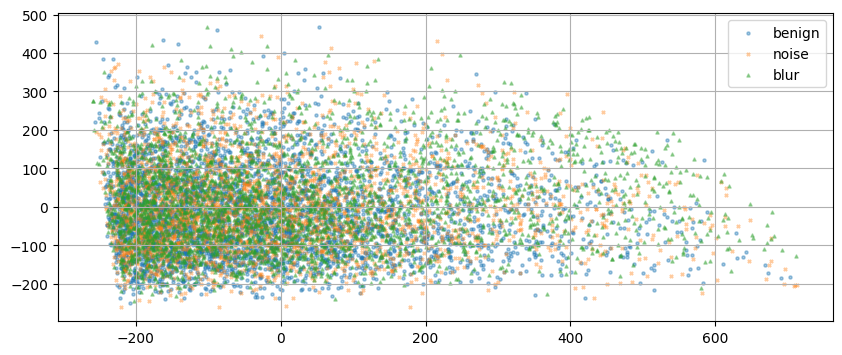

In [4]:
# Dataset 
dataset["test"].load()
X = torch.stack([x for x, _ in dataset["test"].cache])
dataset["test"].clear()

X[4000:7000] = gnoise(X[4000:7000])
X[7000:] = gblur(X[7000:]) 
X = 0.2989 * X[:, 0] + 0.5870 * X[:, 1] + 0.1140 * X[:, 2] 

labels = np.zeros(10000, dtype = int)
labels[4000:7000] = 1 
labels[7000:] = 2

# Fourier domains
beta = .3
num_samples, height, width = X.size()
 
h0, w0 = height // 2,  width // 2 
H, W = int(beta * h0), int(beta * w0)

X_fft = torch.fft.fft2(X, dim = (-2, -1))
X_fft = torch.fft.fftshift(X_fft).abs()
X_fft = X_fft[:, h0-H : h0+H, w0-W : w0+W]
X_fft = X_fft.reshape(num_samples, -1).numpy()

pca = PCA(n_components = 2, random_state = 42).fit(X_fft)
X_fft_pca = pca.transform(X_fft)

plt.figure(figsize = (10, 4))
plt.scatter(X_fft_pca[labels == 0, 0], X_fft_pca[labels == 0, 1], marker = "o", s = 5, alpha = .4, label = "benign")
plt.scatter(X_fft_pca[labels == 1, 0], X_fft_pca[labels == 1, 1], marker = "x", s = 5, alpha = .4, label = "noise")
plt.scatter(X_fft_pca[labels == 2, 0], X_fft_pca[labels == 2, 1], marker = "^", s = 5, alpha = .4, label = "blur")
plt.grid()
plt.legend()
plt.show()

# Detector training

In [5]:
# Train detector
dataset = get_federation(num_shards = 1, alpha = 1000)[0]

# This is not the model we are going to use for real experiments, 
# this is just a demo
model = train_detector(
    train_dataset = dataset["train"],
    test_dataset = dataset["test"],
    discriminant = "fft",
    discriminant_params = {"beta": 0.3},
    num_epochs = 10, 
    batch_size = 64,
    pca_n_components = None,
    device = "cpu"
)

  0%|          | 0/10 [00:00<?, ?it/s]

- Epoch 1: accuracy_score = 0.4949


 10%|█         | 1/10 [00:34<05:07, 34.12s/it]

- Epoch 2: accuracy_score = 0.4949


 20%|██        | 2/10 [01:08<04:33, 34.23s/it]

- Epoch 3: accuracy_score = 0.5051


 30%|███       | 3/10 [01:45<04:10, 35.75s/it]

- Epoch 4: accuracy_score = 0.5051


 40%|████      | 4/10 [02:22<03:35, 35.94s/it]

- Epoch 5: accuracy_score = 0.4949


 50%|█████     | 5/10 [02:59<03:02, 36.44s/it]

- Epoch 6: accuracy_score = 0.4949


 60%|██████    | 6/10 [03:36<02:26, 36.60s/it]

- Epoch 7: accuracy_score = 0.4949


 70%|███████   | 7/10 [04:12<01:49, 36.36s/it]

- Epoch 8: accuracy_score = 0.4949


 80%|████████  | 8/10 [04:48<01:12, 36.38s/it]

- Epoch 9: accuracy_score = 0.5152


100%|██████████| 10/10 [05:26<00:00, 32.69s/it]

- Epoch 10: accuracy_score = 0.5556
